In [3]:
pip install quadprog

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
from math import exp, sqrt
import quadprog

In [5]:
data = pd.read_csv("Echec4_L.txt", sep="\t", names=["x", "y", "Class"])

data.head()

,x,y,Class
0,0.0958,0.0483,1.0
1,0.6370,0.3800,1.0
2,0.4430,0.4130,1.0
3,0.0664,0.4010,1.0
4,0.3740,0.4210,1.0


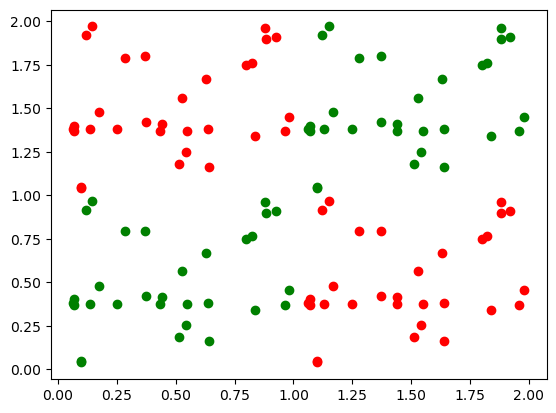

In [6]:
plt.plot(data[data['Class'] == 1]["x"], data[data['Class'] == 1]["y"], 'go')
plt.plot(data[data['Class'] == -1]["x"], data[data['Class'] == -1]["y"], 'ro')
plt.show()

In [7]:
def dist(x):
  return sqrt(x[0]**2+x[1]**2)

In [8]:
def K(x1, x2, sigma):
  return exp(-1/2*(dist(x1-x2)/sigma)**2)

(array([194., 154., 178., 246., 196., 314., 412., 632., 542., 560., 498.,
        500., 560., 518., 650., 712., 882., 636., 476., 546., 500., 518.,
        720., 454., 418., 450., 300., 308., 350., 256., 248., 108., 100.,
         72.,  72.,  42.,  14.,  26.,  24.,   2.,   0.,  12.]),
 array([0.        , 0.0316146 , 0.0632292 , 0.0948438 , 0.12645839,
        0.15807299, 0.18968759, 0.22130219, 0.25291679, 0.28453139,
        0.31614598, 0.34776058, 0.37937518, 0.41098978, 0.44260438,
        0.47421898, 0.50583357, 0.53744817, 0.56906277, 0.60067737,
        0.63229197, 0.66390657, 0.69552116, 0.72713576, 0.75875036,
        0.79036496, 0.82197956, 0.85359416, 0.88520875, 0.91682335,
        0.94843795, 0.98005255, 1.01166715, 1.04328175, 1.07489634,
        1.10651094, 1.13812554, 1.16974014, 1.20135474, 1.23296934,
        1.26458393, 1.29619853, 1.32781313]),
 <BarContainer object of 42 artists>)

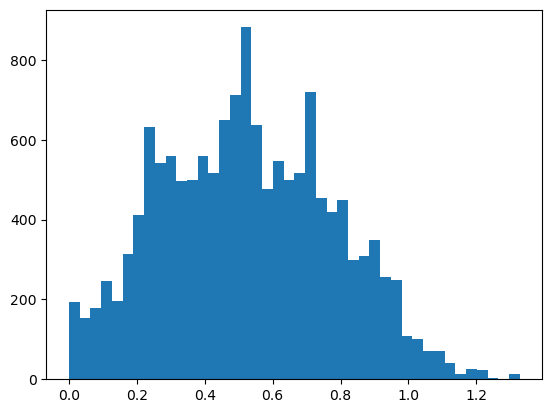

In [9]:
points = np.array(data[["x", "y"]])

points_normalized = np.copy(points)
points_normalized[:,0] = points[:,0]/max(points[:,0])
points_normalized[:,1] = points[:,1]/max(points[:,1])

distances = []
for x1 in points_normalized:
  for x2 in points_normalized:
    distances.append(dist(x1-x2))

plt.hist(distances, bins='auto')

In [10]:
sigma = np.percentile(distances, 5)
sigma

0.11853655213477939

In [11]:
classes = np.array(data[["Class"]])

In [12]:
n = len(points)
eps = 1e-08
G = np.zeros((n, n))

for i,x1 in enumerate(points):
  for j,x2 in enumerate(points):
    G[i,j] = classes[i] * classes[j] * K(x1, x2, sigma)

G += eps * np.identity(n)

rg = matrix_rank(G)

In [13]:
total_sums = []
for x1 in points_normalized:
  sum = 0
  for x2 in points_normalized:
    sum += dist(x1-x2)
  total_sums.append(sum)

data["distances"] = total_sums
data.head()

,x,y,Class,distances
0,0.0958,0.0483,1.0,86.203489
1,0.6370,0.3800,1.0,59.338931
2,0.4430,0.4130,1.0,62.282531
3,0.0664,0.4010,1.0,75.303365
4,0.3740,0.4210,1.0,63.944633


In [14]:
def quadprog_solve_qp(P, q, G, h, A, b):

    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    qp_C = -np.vstack([A, G]).T
    qp_b = -np.hstack([b, h])
    meq = A.shape[0]

    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

In [15]:
f = np.ones([n])
q = np.identity(n)
bineq = np.zeros([n])
Aeq = classes.T
beq = np.array([0.])

meq = Aeq.shape[0]

print("Cost matrix G shape: ", G.shape)
print("Offset shape: ", f.shape)
print("Inequality Constraints shape: ", q.shape)
print("Inequality Constraints offset shape: ", bineq.shape)
print("Equality Constraints shape: ", Aeq.shape)
print("Equality Constraints offset shape: ", beq.shape)

Cost matrix G shape:  (120, 120)
Offset shape:  (120,)
Inequality Constraints shape:  (120, 120)
Inequality Constraints offset shape:  (120,)
Equality Constraints shape:  (1, 120)
Equality Constraints offset shape:  (1,)


In [16]:
lambda_opt = quadprog_solve_qp(G, f, q, bineq, Aeq, beq)
print(lambda_opt.shape)

(120,)


In [17]:
lambda_opt

array([ 6.63754087e-18, -5.50471606e-01,  4.03460411e-17, -1.70686533e-16,
       -4.17579758e-01, -2.11036840e-01, -5.38669248e-01, -5.57077852e-01,
       -2.00072884e-01, -5.89729084e-01, -3.98183675e-01, -2.05816496e-01,
       -1.70108152e+00, -9.89146014e-01, -4.38491240e-01, -1.94483846e-18,
        1.42381203e-17, -7.45538217e-01,  1.54316467e-32,  1.44053118e-17,
        1.54793469e-16, -4.12397723e+00, -4.75491936e-01, -6.97701700e-01,
       -2.62683948e-01, -8.35312579e-17,  3.18506098e-16, -5.15779272e-01,
       -2.46835377e+00,  2.45640187e-16,  1.74806499e-15, -4.96499676e-01,
        3.92863803e-16, -1.27624513e-14, -6.33293078e-01, -8.59738154e-17,
       -2.11233345e-01, -5.28136086e-01, -7.29493698e-01, -5.50556095e-01,
       -6.16556532e-01, -1.04609547e-01, -7.05529328e-01, -9.68674429e-01,
       -4.38091583e-01,  5.28335782e-18,  3.24736151e-17, -7.23601785e-01,
       -3.86431112e+00,  3.35359386e-16, -5.19687202e-01, -4.03753656e+00,
        4.10193088e-18,  

In [18]:
surface = []
for x1 in points_normalized:
  sum = 0
  for k, x2 in enumerate(points_normalized):
    sum += lambda_opt[k] * classes[k] * K(x1, x2, sigma)
  surface.append(sum)

data["surface"] = surface
data.head()

,x,y,Class,distances,surface
0,0.0958,0.0483,1.0,86.203489,[-1.640411457978223]
1,0.6370,0.3800,1.0,59.338931,[-3.254519833689484]
2,0.4430,0.4130,1.0,62.282531,[-3.278044853882679]
3,0.0664,0.4010,1.0,75.303365,[-2.1357044957427056]
4,0.3740,0.4210,1.0,63.944633,[-3.1725013723283086]


In [19]:
b_opt = np.mean(data['Class'] - data['surface'])[0]
b_opt

0.05040288976681572

In [20]:
data['surface'] += b_opt
data.head()

,x,y,Class,distances,surface
0,0.0958,0.0483,1.0,86.203489,[-1.5900085682114073]
1,0.6370,0.3800,1.0,59.338931,[-3.204116943922668]
2,0.4430,0.4130,1.0,62.282531,[-3.2276419641158633]
3,0.0664,0.4010,1.0,75.303365,[-2.0853016059758898]
4,0.3740,0.4210,1.0,63.944633,[-3.122098482561493]


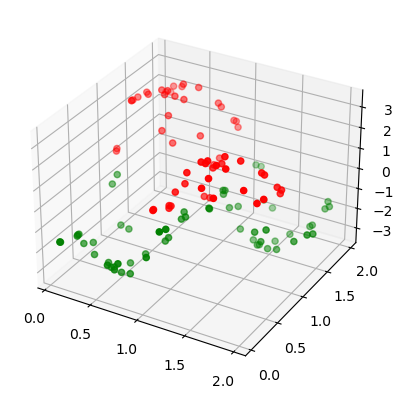

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = list(data[data['Class'] == 1]["x"])
y = list(data[data['Class'] == 1]["y"])
z = list(data[data['Class'] == 1]["surface"])
ax.scatter(x, y, z, c='g', marker='o')

x = list(data[data['Class'] == -1]["x"])
y = list(data[data['Class'] == -1]["y"])
z = list(data[data['Class'] == -1]["surface"])
ax.scatter(x, y, z, c='r', marker='o')

plt.show()

In [22]:
print("Max x: " + str(data['x'].max()))
print("Min x: " + str(data['x'].min()))
print("Max y: " + str(data['y'].max()))
print("Min y: " + str(data['y'].min()))

Max x: 1.98
Min x: 0.0647
Max y: 1.97
Min y: 0.0386


In [41]:
coordsX = np.linspace(data['x'].min(), data['x'].max(), 50)
coordsY = np.linspace(data['y'].min(), data['y'].max(), 50)

pred = []
for x in coordsX:
    for y in coordsY:
        pred.append([x, y])

predictions = pd.DataFrame(data=pred, columns=['x', 'y'])
predictions.head()

,x,y
0,0.0647,0.038600
1,0.0647,0.078016
2,0.0647,0.117433
3,0.0647,0.156849
4,0.0647,0.196265


In [42]:
points_pred = np.array(predictions[["x", "y"]])

points_normalized_pred = np.copy(points_pred)
points_normalized_pred[:,0] = points_pred[:,0]/max(points_pred[:,0])
points_normalized_pred[:,1] = points_pred[:,1]/max(points_pred[:,1])

surface = []
for x1 in points_normalized_pred:
  sum = 0
  for k, x2 in enumerate(points_normalized):
    sum += lambda_opt[k] * classes[k] * K(x1, x2, sigma)
  surface.append(sum[0] + b_opt)

predictions["surface"] = surface
predictions.head()

,x,y,surface
0,0.0647,0.038600,-1.492253
1,0.0647,0.078016,-1.617699
2,0.0647,0.117433,-1.730684
3,0.0647,0.156849,-1.829808
4,0.0647,0.196265,-1.913923


In [43]:
predictions['Class'] = 1
predictions['Class'][predictions['surface'] > 0] = -1

C:\Users\fafou\AppData\Local\Temp\ipykernel_14676\3575728038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['Class'][predictions['surface'] > 0] = -1


In [44]:
predictions.head()

,x,y,surface,Class
0,0.0647,0.038600,-1.492253,1
1,0.0647,0.078016,-1.617699,1
2,0.0647,0.117433,-1.730684,1
3,0.0647,0.156849,-1.829808,1
4,0.0647,0.196265,-1.913923,1


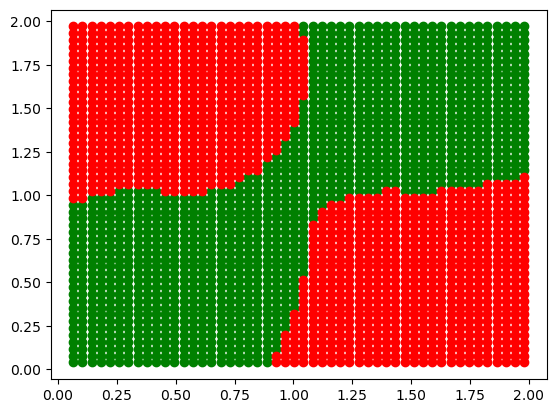

In [45]:
plt.plot(predictions[predictions['Class'] == 1]["x"], predictions[predictions['Class'] == 1]["y"], 'go')
plt.plot(predictions[predictions['Class'] == -1]["x"], predictions[predictions['Class'] == -1]["y"], 'ro')
plt.show()

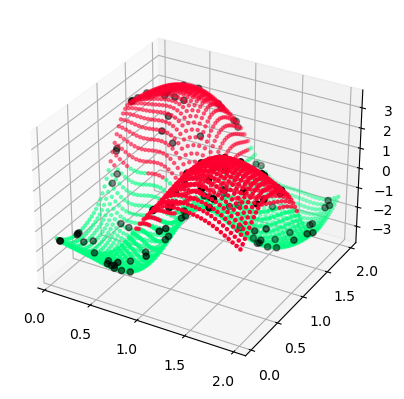

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = list(predictions[predictions['Class'] == 1]["x"])
y = list(predictions[predictions['Class'] == 1]["y"])
z = list(predictions[predictions['Class'] == 1]["surface"])
ax.scatter(x, y, z, c='#00ff80', marker='.')

x = list(predictions[predictions['Class'] == -1]["x"])
y = list(predictions[predictions['Class'] == -1]["y"])
z = list(predictions[predictions['Class'] == -1]["surface"])
ax.scatter(x, y, z, c='#ff002f', marker='.')

x = list(data["x"])
y = list(data["y"])
z = list(data["surface"])
ax.scatter(x, y, z, c='black', marker='o')

plt.show()